# Sign Language Recognition

Dalang Felix Sihitshuwam \
Email: f.dalang@innopolis.university

Otobong Jerome Bassey \
Email: o.jerome@innopolis.university

Briefly, in this task, we seek to develop and train a model which classifies hand signs.

# Data Loading and Preprocessing.

In [ ]:
import os
import cv2
import glob
import numpy as np
import pandas as pd

from google.colab.patches import cv2_imshow
from IPython.display import clear_output

In [ ]:
if not 'train_data' in os.listdir():
  !unzip ./drive/MyDrive/DataSet/asl_alphabet_train.zip -d train_data
  clear_output()

if not 'test_data' in os.listdir():
  !unzip ./drive/MyDrive/DataSet/asl_alphabet_test.zip -d test_data
  clear_output()

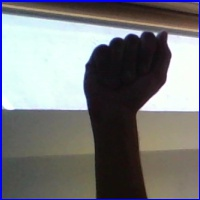

In [ ]:
img_folder = "./test_data/asl_alphabet_test/"
img_path = f'{img_folder}A_test.jpg'
image = cv2.imread(img_path)

cv2_imshow(image)

Convert to greyscale

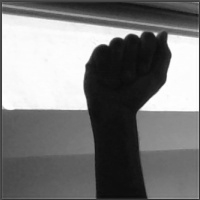

(200, 200)


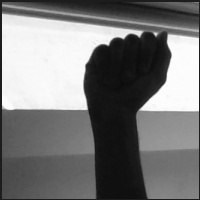

In [ ]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
cv2_imshow(gray)
print(gray.shape)
gray2 = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
cv2_imshow(gray2)

In [ ]:
labels_dict = dict([(j.split('_')[0], i) for i, j in enumerate(sorted(os.listdir('./train_data/asl_alphabet_train/')))])
print(labels_dict)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


# Model Design and Training

In [ ]:
import glob
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

In [ ]:
class CustomDataset(Dataset):
  """"""
  def __init__(self, labels_dict, img_dir, transform=None, target_transform=None):
      self.labels_dict = labels_dict
      self.img_dir = img_dir
      self.images = [i for i in glob.glob(f"{img_dir}*.jpg")]
      self.transform = transform
      self.target_transform = target_transform

  def __len__(self):
      return len(self.images)

  def __getitem__(self, idx):
      img_path = self.images[idx]
      fname = os.path.basename(img_path)
      label = self.labels_dict[fname.split('_')[0]]
      image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

      if self.transform:
          image = self.transform(image)
      if self.target_transform:
          label = self.target_transform(label)
      return image, label
  
class TrainDataset(Dataset):
  """"""
  def __init__(self, labels_dict, img_dir, transform=None, target_transform=None):
      self.labels_dict = labels_dict
      self.img_dir = img_dir
      self.images = []
      for j in sorted(os.listdir(img_dir)):
        self.images.extend([(i, j) for i in glob.glob(f"{img_dir}/{j}/*.jpg")])
      self.transform = transform
      self.target_transform = target_transform

  def __len__(self):
      return len(self.images)

  def __getitem__(self, idx):
      img_path, letter = self.images[idx]
      label = self.labels_dict[letter]
      image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

      if self.transform:
          image = self.transform(image)
      if self.target_transform:
          label = self.target_transform(label)
      return image, label

In [ ]:
test_data = CustomDataset(
    labels_dict=labels_dict,
    img_dir="./test_data/asl_alphabet_test/",
    transform=transforms.ToTensor(),
    target_transform=transforms.Lambda(lambda y: torch.zeros(len(labels_dict), dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

In [ ]:
train_data = TrainDataset(
    labels_dict=labels_dict,
    img_dir="./train_data/asl_alphabet_train/",
    transform=transforms.ToTensor(),
    target_transform=transforms.Lambda(lambda y: torch.zeros(len(labels_dict), dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

In [ ]:
sample_idx = torch.randint(len(test_data), size=(1,)).item()
img, label = test_data[sample_idx]
print(test_data.images[sample_idx])
print(label)
# cv2_imshow(img)

./test_data/asl_alphabet_test/M_test.jpg
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [ ]:
len(train_data)
sample_idx = torch.randint(len(train_data), size=(1,)).item()
img, label = train_data[sample_idx]
print(train_data.images[sample_idx][1])
print(label)

L
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [ ]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=20, shuffle=True)

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.model = nn.Sequential(
            # 200 x 200 x 1
            nn.Conv2d(1, 64, kernel_size=5, padding=2), # to get desired output
            nn.ReLU(),
            # 200 x 200 x 64
            nn.MaxPool2d(2, 2),
            # 100 x 100 x 64
            nn.Conv2d(64, 128, 5, padding=2),
            nn.ReLU(),
            # 100 x 100 x 128
            nn.MaxPool2d(2, 2),
            # 50 x 50 x 128
            nn.Conv2d(128, 256, 5, padding=2),
            nn.ReLU(),
            # 50 x 50 x 256
            nn.ConvTranspose2d(256, 128, 4, stride=4, padding=0),
            nn.ReLU(),
            # 200 x 200 x 128
            nn.ConvTranspose2d(128, 64, 5, padding=2),
            nn.ReLU(),
            # 200 x 200 x 64
            nn.ConvTranspose2d(64, 1, 5, padding=2),
            # 200 x 200 x 1
            nn.Flatten(),
            nn.Linear(200*200, 450),
            nn.ReLU(),
            nn.Linear(450, 28),
        )

    def forward(self, x):
        logits = self.model(x)
        return logits

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


Methods For Training and Testing

In [ ]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    tot_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        print(data.size(), target.size())
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        tot_loss += loss.item()
        loss.backward()
        optimizer.step()
    return tot_loss/len(train_loader)
            
def test( model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format( test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct/len(test_loader.dataset)

In [ ]:
model = Network().to(device)
print(model)

Network(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(4, 4))
    (9): ReLU()
    (10): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (11): ReLU()
    (12): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=40000, out_features=450, bias=True)
    (15): ReLU()
    (16): Linear(in_features=450, out_features=28, bias=True)
  )
)


In [ ]:
learning_rate = 1e-3
epochs = 5

criterion = nn.Softmax()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
  tr_loss = train(model, device, train_dataloader, optimizer, criterion)
  print(tr_loss)
  ts_loss, acc = test(model, device, test_dataloader, criterion)

torch.Size([64, 1, 200, 200]) torch.Size([64, 29])


TypeError: ignored

In [ ]:
# img_dir="./train_data/asl_alphabet_test/"
# images = [i for i in glob.glob(f"{img_dir}*.jpg")]
# for f in images:
#   os.remove(f)